# Exercício: *Fine-tuning* do BERT em análise de sentimento de avaliações de filme do IMDB

**Nome:** Caio Petrucci dos Santos Rosa

**RA:** 248245

## Instruções:


Treinar e medir a acurácia de um modelo BERT (ou variantes) para classificação binária usando o dataset do IMDB (20k/5k amostras de treino/validação).

Importante:
- Deve-se implementar o próprio laço de treinamento.
- Implementar o acumulo de gradiente.

Dicas:
- BERT geralmente costuma aprender bem uma tarefa com poucas épocas (de 3 a 5 épocas). Se tiver demorando mais de 5 épocas para chegar em 80% de acurácia, ajuste os hiperparametros.

- Solução para erro de memória:
  - Usar bfloat16 permite quase dobrar o batch size

Opcional:
- Pode-se usar a função trainer da biblioteca Transformers/HuggingFace para verificar se seu laço de treinamento está correto. Note que ainda assim é obrigatório implementar o laço próprio.

# Bibliotecas e pacotes

In [ ]:
import os
import random
import re
import string
import time
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from transformers import DistilBertModel, DistilBertForSequenceClassification, DistilBertTokenizer, get_linear_schedule_with_warmup
from tqdm import tqdm

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

In [ ]:
# Essa flag deve ser utilizada para facilitar a detecção de erros durante a implementação do modelo
# Definir como False sempre e como True apenas para debugging
torch.autograd.set_detect_anomaly(False)

# Modelo BERT pré-treinado

Iremos utilizar como base, ao longo de todo o notebook, o seguinte checkpoint do modelo BERT:

In [ ]:
bert_checkpoint = 'distilbert/distilbert-base-uncased'

# Dataset e pré-processamento dos dados

O dataset utilizado é o `aclImdb` (https://ai.stanford.edu/~amaas/data/sentiment/). Neste conjunto, já estão separados os conjuntos de treinamento e de teste, cada um contendo 25.000 amostras.

Também, definimos o hiper-parâmetro `seq_length`, que é determinante na forma como os dados serão pré-processados:

In [ ]:
seq_length = 512

## Download do dataset

In [ ]:
!wget -nc http://files.fast.ai/data/aclImdb.tgz
!tar -xzf aclImdb.tgz

File ‘aclImdb.tgz’ already there; not retrieving.



## Conjuntos de treinamento, de validação e de teste

Para o treinamento e avaliação do nosso modelo, baseado no BERT pré-treinado, iremos construir 3 conjuntos de dados:

1. Treinamento: 20.000 amostras;
2. Validação: 5.000 amostras;
3. Teste: 25.000 amostras.

O conjunto original de treinamento será dividido em 2 conjuntos: de treinamento, com 80% dos dados, e de validação, com 20%. Ambos serão utilizados durante o treinamento, sendo que os parâmetros do modelo são ajustados apenas considerando o conjunto de treinamento enquanto que o conjunto de validação será utilizado ao longo desse processo para avaliar se o modelo está sofrendo *overfitting* e generalizando bem o problema.

O conjunto de teste foi utilizado, apenas após o treinamento, para avaliar o modelo final.

Definimos as duas funções auxiliares:

- `load_texts`: carrega amostras de texto, contidas dentro de uma pasta `folder`, e retorna uma lista de textos;

- `load_data`: carrega dados, contidos na pasta `data_path`, com duas classes, cada uma armazenada em uma subpasta de `data_path` (`/pos` e `/neg`), e retorna os dados `X`e `y` do conjunto construído.

In [ ]:
# Le todos os textos contidos dentro de uma pasta e retorna uma lista de textos
def load_texts(folder):
    texts = []
    for path in os.listdir(folder):
        with open(os.path.join(folder, path)) as f:
            texts.append(f.read())
    return texts

In [ ]:
def load_data(data_path):
    X_pos = load_texts(f'{data_path}/pos')
    y_pos = [1] * len(X_pos)

    X_neg = load_texts(f'{data_path}/neg')
    y_neg = [0] * len(X_neg)

    X = X_pos + X_neg
    y = y_pos + y_neg

    return X, y

Constrói os conjuntos e divide em treinamento, validação e teste:

In [ ]:
X_train, y_train = load_data('aclImdb/train')
X_test, y_test = load_data('aclImdb/test')

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

In [ ]:
def print_samples(X_data, y_data, k):
    indexes = list(range(0, k)) + list(range(len(X_data)-k, len(X_data)))
    for i in indexes:
        X = X_data[i]
        y = y_data[i]
        print(f'Amostra {i+1}:')
        print(f'\tTexto:\t{X}')
        print(f'\tLabel:\t{"Positive" if y == 1 else "Negative"}')

In [ ]:
print('    Conjunto de Treinamento    ')
print('===============================')
print()
print_samples(X_train, y_train, k=2)

    Conjunto de Treinamento    

Amostra 1:
	Texto:	I know I know it was a good ending but sincerely it was awesome. I love when a movie ends on a terrific dark nature but this time I was impressed with Darth Vader turning against the Emperor I really stayed astonished. The anguishing sequence in that film was when Luke is tortured and defeated by the Emperor/Darth Sidious. He is about to be destroyed when Darth Vader, Dark Lord of the Sith, eliminates his dark master. A nice sacrifice. The cinematography of this film is impressive. I was surprised with all the vessels of the Rebel Battle ships and all Imperial War Ships and Super Star Destroyers. I loved the new race they brought on screen the Mon Calomari, the ewoks, the sullesteian (Lando's co pilot) and many more... Most of my favorite scenes are in that film:1-When Vader destroys the Emperor and is fatally wounded. 2- When Luke sees the spirits of Obi-Wan and Yoda and then it shows up Anakin Skywalker (Sebastian Shaw)(the greatest

In [ ]:
print('     Conjunto de Validação    ')
print('===============================')
print()
print_samples(X_val, y_val, k=2)

     Conjunto de Validação    

Amostra 1:
	Texto:	Ben & Arthur COULD have been a 10. Sam Mraovich wrote, directed, stared, and produced this movie. Sam should have given his idea to a good writer, director, and left the acting to somebody who could act. this is a good example of one person controlling the whole production. there was nobody to tell him, "Sam this is bad, really bad".<br /><br />Jamie Brett Gabel's acting was the only good point, but he could have been so much better with a good director, and better actors to work with. <br /><br />This movie is so bad i think Sam Mraovich should be tied to a chair and made to watch this movie (twice). the acting and direction was so bad, this movie was turned into a comedy. you just had to laugh, and in the wrong places. <br /><br />A second good point....this would make a great date movie. after the first two minutes you would quit watching the movie and pay more attention to your date!
	Label:	Negative
Amostra 2:
	Texto:	Cinderella i

In [ ]:
print('       Conjunto de Teste       ')
print('===============================')
print()
print_samples(X_test, y_test, k=2)

       Conjunto de Teste       

Amostra 1:
	Texto:	This is a great movie, all 3 were. The last one was not as good as the first 2 but it was made along time after and it was pulling at straws. But you want to watch it cause it tells the end of the story. Just not how we might think it should end.<br /><br />These movies made me want to be there to be in all the hardship, love, tears, and laughter that the people in this movie go threw. It is one of the few movies that is good every time you see it no matter how many times that is.<br /><br />There are some parts in the movie that the little kids wont understand and the older ones maynot be old enough to watch. but it is a great movie, spanning over 20+ years.
	Label:	Positive
Amostra 2:
	Texto:	The Beat was an exciting movie about a couple of young punks trying to survive in 1980's New York. This involves fighting with the other street gang that they directly share a high school class with, trying to stay in school, as well as going t

## Tokenização através da biblioteca HuggingFace

Para a construção das amostras a partir dos dados, iremos tokenizar cada amostra crua utilizando o `BertTokenizer`, a partir da biblioteca `HuggingFace`:

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained(bert_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
print(' BERT Tokenizer ')
print('================')
print()
print(tokenizer)

 BERT Tokenizer 

DistilBertTokenizer(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


In [ ]:
outputs = tokenizer(
    'Hi, my name is Caio!',
    return_tensors="pt",
    return_token_type_ids=False,
    add_special_tokens=True,
    padding='max_length',
    max_length=12,
    truncation=True,
)

for k, v in outputs.items():
    print(f'\'{k}\':\t{v}')

'input_ids':	tensor([[  101,  7632,  1010,  2026,  2171,  2003, 29080,  2080,   999,   102,
             0,     0]])
'attention_mask':	tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])


In [ ]:
outputs = tokenizer(
    X_train[:32],
    return_tensors="pt",
    return_token_type_ids=False,
    add_special_tokens=True,
    padding='max_length',
    max_length=seq_length,
    truncation=True,
)

for k, v in outputs.items():
    print(f'\'{k}\':\t{v.shape}')

'input_ids':	torch.Size([32, 512])
'attention_mask':	torch.Size([32, 512])


## Classe `ReviewDataset`

Definimos a classe `ReviewDataset` que será utilizada em conjunto com a classe `DataLoader` do PyTorch:

In [ ]:
class ReviewDataset:
    def __init__(self, tokenizer, seq_length, X, y, verbose=False):
        if verbose:
            print(f'Tokenizando {len(X)} textos do dataset...')
            start = time.time()
        self.X = tokenizer(
            X,
            return_tensors="pt",
            return_token_type_ids=False,
            add_special_tokens=True,
            padding='max_length',
            max_length=seq_length,
            truncation=True,
        )
        if verbose:
            end = time.time()
            duration = end - start
            print(f'Textos tokenizados em {duration:.2f} sec.')

        self.y = torch.LongTensor(y)

        self._len = len(X)

    def __getitem__(self, idx):
        item = { k: v[idx] for k, v in self.X.items() }
        item["labels"] = self.y[idx]
        return item

    def __len__(self):
        return self._len

Então, instanciamos os datasets de treinamento, validação e teste:

In [ ]:
def create_dataset(name, tokenizer, seq_length, X, y, verbose=False):
    print(f'Criando o dataset de {name}...')

    start = time.time()
    dataset = ReviewDataset(tokenizer, seq_length, X, y, verbose)
    end = time.time()
    duration = end - start

    print(f'Dataset de {name} criado em {duration:.2f} sec.\n')

    return dataset

In [ ]:
train_data = create_dataset('treinamento', tokenizer, seq_length, X_train, y_train, verbose=True)
val_data = create_dataset('validação', tokenizer, seq_length, X_val, y_val, verbose=True)
test_data = create_dataset('teste', tokenizer, seq_length, X_test, y_test, verbose=True)

Criando o dataset de treinamento...
Tokenizando 20000 textos do dataset...
Textos tokenizados em 163.94 sec.
Dataset de treinamento criado em 163.94 sec.

Criando o dataset de validação...
Tokenizando 5000 textos do dataset...
Textos tokenizados em 26.72 sec.
Dataset de validação criado em 26.72 sec.

Criando o dataset de teste...
Tokenizando 25000 textos do dataset...
Textos tokenizados em 129.11 sec.
Dataset de teste criado em 129.11 sec.



Análise sobre os conjuntos de dados:

In [ ]:
print(f'Treinamento:\t{len(train_data):,d}\tamostras')
print(f'Validação:\t{len(val_data):,d}\tamostras')
print(f'Teste:\t\t{len(test_data):,d}\tamostras')

Treinamento:	20,000	amostras
Validação:	5,000	amostras
Teste:		25,000	amostras


In [ ]:
is_positive = lambda sample: sample["labels"].item() == 1
p_positive = lambda data: len(list(filter(is_positive, data))) / len(data)
p_complement = lambda p: 1-p

train_positive = p_positive(train_data)
val_positive = p_positive(val_data)
test_positive = p_positive(test_data)

print(f'Treinamento:\t{train_positive*100:.2f} % amostras positivas / {p_complement(train_positive)*100:.2f} % amostras negativas')
print(f'Validação:\t{val_positive*100:.2f} % amostras positivas / {p_complement(val_positive)*100:.2f} % amostras negativas')
print(f'Teste:\t\t{test_positive*100:.2f} % amostras positivas / {p_complement(test_positive)*100:.2f} % amostras negativas')

Treinamento:	50.19 % amostras positivas / 49.81 % amostras negativas
Validação:	49.26 % amostras positivas / 50.74 % amostras negativas
Teste:		50.00 % amostras positivas / 50.00 % amostras negativas


# BERT através da biblioteca HuggingFace

Então, iremos instanciar objetos `DistilBertTokenizer`, `DistilBertModel` e `DistilBertForSequenceClassification` da HuggingFace, utilizando como base o checkpoint `google-bert/bert-base-cased`.

Também, utilizaremos uma função `print_number_of_parameters` para imprimir a quantidade de parâmetros de um modelo PyTorch arbitrário.

In [ ]:
def print_number_of_parameters(model):
    n_params = sum(p.numel() for p in model.parameters())
    n_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Número de parâmetros: \t\t\t {n_params:,d}')
    print(f'Número de parâmetros treináveis: \t {n_trainable_params:,d}')

In [ ]:
base_model = DistilBertModel.from_pretrained(bert_checkpoint)

In [ ]:
print('                  Base BERT Model                   ')
print('====================================================')
print()
print_number_of_parameters(base_model)
print()
print('Sumário do modelo:')
print(base_model)

                  Base BERT Model                   

Número de parâmetros: 			 66,362,880
Número de parâmetros treináveis: 	 66,362,880

Sumário do modelo:
DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      

In [ ]:
seq_classification_model = DistilBertForSequenceClassification.from_pretrained(bert_checkpoint)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print('         Sequence Classification BERT Model         ')
print('====================================================')
print()
print_number_of_parameters(seq_classification_model)
print()
print('Sumário do modelo:')
print(seq_classification_model)

         Sequence Classification BERT Model         

Número de parâmetros: 			 66,955,010
Número de parâmetros treináveis: 	 66,955,010

Sumário do modelo:
DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )


Exemplificação de tokenização e do *forward pass*:

In [ ]:
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)

In [ ]:
inputs = next(iter(train_loader))

print(f'Inputs:')
for k, v in inputs.items():
    print(f'\t\'{k}\' shape:\t{v.shape}')

Inputs:
	'input_ids' shape:	torch.Size([4, 512])
	'attention_mask' shape:	torch.Size([4, 512])
	'labels' shape:	torch.Size([4])


In [ ]:
outputs = seq_classification_model(**inputs)
outputs

SequenceClassifierOutput(loss=tensor(0.7192, grad_fn=<NllLossBackward0>), logits=tensor([[-0.0453,  0.0421],
        [-0.0004,  0.0280],
        [-0.0319,  0.0547],
        [-0.0239,  0.0343]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
l_predicted = torch.argmax(outputs.logits, dim=1)
l_predicted

tensor([1, 1, 1, 1])

In [ ]:
probs = F.softmax(outputs.logits, dim=1)
probs

tensor([[0.4782, 0.5218],
        [0.4929, 0.5071],
        [0.4784, 0.5216],
        [0.4855, 0.5145]], grad_fn=<SoftmaxBackward0>)

In [ ]:
p_predicted = torch.argmax(probs, dim=1)
p_predicted

tensor([1, 1, 1, 1])

In [ ]:
inputs['labels']

tensor([0, 1, 0, 0])

In [ ]:
l_acc = (l_predicted == inputs['labels']).sum().item() / len(l_predicted)
l_acc

0.25

In [ ]:
p_acc = (p_predicted == inputs['labels']).sum().item() / len(p_predicted)
p_acc

0.25

# Treinamento

O modelo foi treinado avaliando, a cada época, a Cross Entropy e a Perplexidade no conjunto de treinamento e de validação.

## Métodos e funções para treinamento

In [ ]:
def eval_model_on_data(model, data_loader, device):
    criterion = nn.CrossEntropyLoss()

    model.eval()
    with torch.no_grad():
        correct_pred, losses, total = 0, 0, 0

        for batch in tqdm(data_loader):
            batch = { k: v.to(device) for k, v in batch.items() }
            bsz = batch['labels'].size(0)
            labels = batch['labels']

            outputs = model(**batch)
            loss = criterion(outputs.logits, labels)
            pred = torch.argmax(outputs.logits, dim=1)

            correct_pred += torch.eq(pred, labels).sum().item()
            losses += loss * bsz
            total += bsz

    loss = losses / total
    acc = correct_pred / total
    ppl = torch.exp(loss)

    return loss.item(), ppl.item(), acc

In [ ]:
def add_step_on_hist(hist, train_loss, train_ppl, train_acc, val_loss, val_ppl, val_acc):
    hist["loss_train"].append(train_loss)
    hist["ppl_train"].append(train_ppl)
    hist["acc_train"].append(train_acc)

    hist["loss_val"].append(val_loss)
    hist["ppl_val"].append(val_ppl)
    hist["acc_val"].append(val_acc)

In [ ]:
def plot_hist(hist, prop, prop_name):
    plt.plot(hist[f"{prop}_train"], "o-")
    plt.plot(hist[f"{prop}_val"], "o-")

    plt.legend(["Treinamento", "Validação"])
    plt.xlabel("Época")
    plt.ylabel(prop_name)
    plt.title(f"Histórico da {prop_name}")

    plt.show()

In [ ]:
def print_eval_metrics(dataset, loss, ppl, acc, eval_duration):
    title = f'Avaliação no conjunto de {dataset}:'
    print(title)
    print('-' * len(title))
    print(f'Loss:\t{loss:.4f}')
    print(f'PPL:\t{ppl:.4f}')
    print(f'Acc:\t{acc*100:.4f}%')
    print(f'Tempo:\t{eval_duration:.2f} sec')
    print()

In [ ]:
def print_epoch_info(
    epoch,
    epoch_duration,
    n_epochs,
    train_loss,
    train_ppl,
    train_acc,
    val_loss,
    val_ppl,
    val_acc
):
    print(f'Época [{str(epoch+1).zfill(len(str(n_epochs)))}/{n_epochs}], \
            Train Loss: {train_loss:.4f}, \
            Train PPL: {train_ppl:.4f}, \
            Train Acc: {train_acc*100:.4f}%, \
            Val Loss: {val_loss:.4f}, \
            Val PPL: {val_ppl:.4f}, \
            Val Acc: {val_acc*100:.4f}%, \
            Tempo: {epoch_duration:.2f} sec')

In [ ]:
def train(
    model,
    train_data,
    val_data,
    batch_size,
    n_epochs,
    lr,
    betas,
    eps,
    weight_decay,
):
    # Inicializa os dataloaders de treinamento e de validação
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)


    # Inicializa o histórico do treinamento do modelo
    hist = { "loss_train": [], "loss_val": [], "ppl_train": [], "ppl_val": [], "acc_train": [], "acc_val": [], }


    # Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device, dtype=torch.bfloat16)
    print(f'Utilizando o device {next(model.parameters()).device} para realizar o treinamento.\n')


    # Avalia a loss e a perplexidade antes do treinamento
    print('Avaliando o modelo inicializado no conjunto de treinamento...')
    start_time = time.time()
    initial_train_loss, initial_train_ppl, initial_train_acc = eval_model_on_data(model, train_loader, device)
    end_time = time.time()
    train_duration = end_time - start_time

    print('Avaliando o modelo inicializado no conjunto de validação...')
    start_time = time.time()
    initial_val_loss, initial_val_ppl, initial_val_acc = eval_model_on_data(model, val_loader, device)
    end_time = time.time()
    val_duration = end_time - start_time

    print_eval_metrics('treinamento', initial_train_loss, initial_train_ppl, initial_train_acc, train_duration)
    print_eval_metrics('validação', initial_val_loss, initial_val_ppl, initial_val_acc, val_duration)

    add_step_on_hist(hist, initial_train_loss, initial_train_ppl, initial_train_acc, initial_val_loss, initial_val_ppl, initial_val_acc)


    print('   Treinamento   ')
    print('-----------------')

    # Otimizador AdamW e Linear Scheduler
    #   implementação do scheduler inspirada no código do Leandro Carísio
    num_training_steps = n_epochs * len(train_loader)
    num_warmup_steps = int(num_training_steps * 0.1)
    optimizer = optim.AdamW(
        model.parameters(),
        lr=lr,
        betas=betas,
        eps=eps,
        weight_decay=weight_decay,
    )
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

    # Criterion / Loss function
    criterion = nn.CrossEntropyLoss()

    # Laço de treinamento
    for epoch in range(n_epochs):
        # Tempo de inicio da epoca
        start_time = time.time()

        # Acumuladores para calculo da loss no conjunto de treinamento
        correct_pred, losses, total = 0, 0, 0

        # Laço da época
        model.train()
        for batch in tqdm(train_loader):
            batch = { k: v.to(device) for k, v in batch.items() }
            bsz = batch['labels'].size(0)
            labels = batch['labels']

            # Forward pass
            outputs = model(**batch)
            loss = criterion(outputs.logits, labels)

            # Backward and otimizacao
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Acumulo das metricas
            pred = torch.argmax(outputs.logits, dim=1)
            correct_pred += torch.eq(pred, labels).sum().item()
            losses += loss * bsz
            total += bsz

        # Calculo da loss e da ppl da época no conjunto de treinamento e de validação
        train_loss = losses / total
        train_ppl = torch.exp(loss)
        train_acc = correct_pred / total
        val_loss, val_ppl, val_acc = eval_model_on_data(model, val_loader, device)

        # Tempo de fim da epoca e de duracao da epoca
        end_time = time.time()
        epoch_duration = end_time - start_time

        # Imprime e salva as informacoes da epoca atual
        add_step_on_hist(hist, train_loss.item(), train_ppl.item(), train_acc, val_loss, val_ppl, val_acc)
        print_epoch_info(epoch, epoch_duration, n_epochs, train_loss.item(), train_ppl.item(), train_acc, val_loss, val_ppl, val_acc)

    # Transforma as listas do histórico em np.array
    for key in hist:
        hist[key] = np.array(hist[key])

    # Retorna o modelo e o histórico de treinamento
    return model, hist

## Execução do treinamento

Definimos os hiper-parâmetros de treinamento, como *learning rate* e o *weight decay*:

In [ ]:
batch_size = 64
n_epochs = 2
lr = 2e-5
weight_decay = 1e-4
betas = (0.9, 0.98)
eps = 1e-8

Então, instanciamos um modelo e realizamos o treinamento, chamando a função `train` implementada anteriormente:

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(bert_checkpoint)
model, hist = train(
    model,
    train_data,
    val_data,
    batch_size,
    n_epochs,
    lr,
    betas,
    eps,
    weight_decay,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Utilizando o device cuda:0 para realizar o treinamento.

Avaliando o modelo inicializado no conjunto de treinamento...


100%|██████████| 313/313 [07:03<00:00,  1.35s/it]


Avaliando o modelo inicializado no conjunto de validação...


100%|██████████| 79/79 [01:45<00:00,  1.33s/it]


Avaliação no conjunto de treinamento:
-------------------------------------
Loss:	0.7188
PPL:	2.0469
Acc:	57.1100%
Tempo:	423.38 sec

Avaliação no conjunto de validação:
-----------------------------------
Loss:	0.7305
PPL:	2.0781
Acc:	58.2600%
Tempo:	105.47 sec

   Treinamento   
-----------------


100%|██████████| 79/79 [01:45<00:00,  1.34s/it]


Época [1/2],             Train Loss: 0.4102,             Train PPL: 1.2734,             Train Acc: 78.1050%,             Val Loss: 0.2910,             Val PPL: 1.3359,             Val Acc: 88.9600%,             Tempo: 1360.75 sec


100%|██████████| 79/79 [01:45<00:00,  1.34s/it]


Época [2/2],             Train Loss: 0.3203,             Train PPL: 1.2578,             Train Acc: 88.4650%,             Val Loss: 0.2812,             Val PPL: 1.3281,             Val Acc: 89.2600%,             Tempo: 1361.94 sec


Podemos analisar o gráfico do histórico da *loss*, em épocas, conforme o treinamento ocorreu:

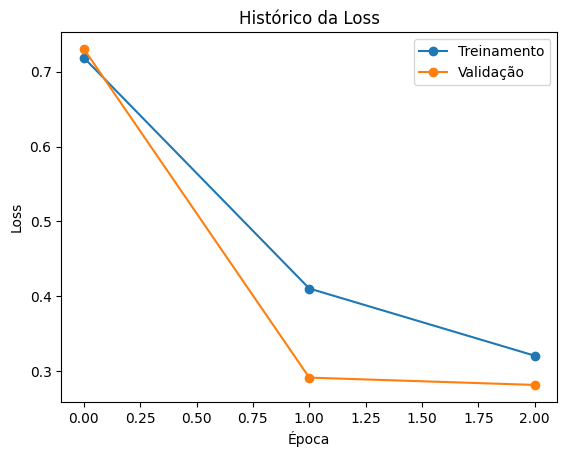

In [ ]:
plot_hist(hist, prop='loss', prop_name='Loss')

Podemos analisar o gráfico do histórico da *perplexidade*, em épocas, conforme o treinamento ocorreu:

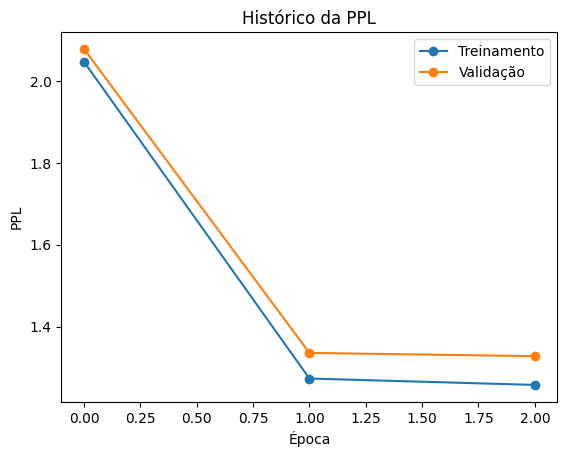

In [ ]:
plot_hist(hist, prop='ppl', prop_name='PPL')

Podemos analisar o gráfico do histórico da *acurácia*, em épocas, conforme o treinamento ocorreu:

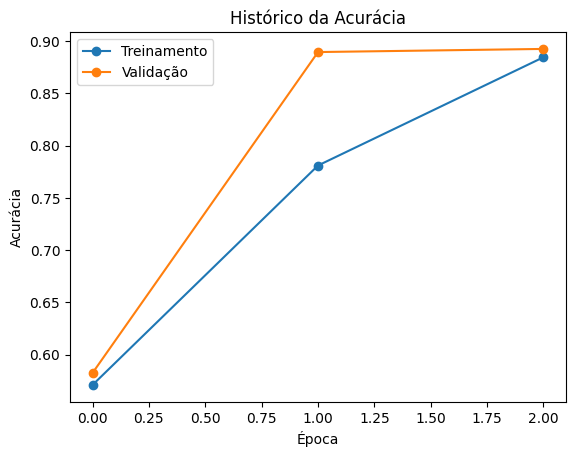

In [ ]:
plot_hist(hist, prop='acc', prop_name='Acurácia')

# Avaliação

In [ ]:
# Cria o DataLoader do conjunto de teste
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Avaliando o modelo treinado no conjunto de teste...')

# Avalia modelo treinado nos dados de teste
start_time = time.time()
loss, ppl, acc = eval_model_on_data(model, test_loader, device)
end_time = time.time()
eval_duration = end_time - start_time

print_eval_metrics('teste', loss, ppl, acc, eval_duration)

Avaliando o modelo treinado no conjunto de teste...


100%|██████████| 391/391 [08:47<00:00,  1.35s/it]

Avaliação no conjunto de teste:
-------------------------------
Loss:	0.3008
PPL:	1.3516
Acc:	88.7480%
Tempo:	527.16 sec



# Exemplificação

In [ ]:
text_review = "The Beat was an exciting movie about a couple of young punks trying to survive in 1980's New York. This involves fighting with the other street gang that they directly share a high school class with, trying to stay in school, as well as going to local shows that involve bands that look like the Dead Kennedy's and have the name Skulls for their band name. Rex (played by David Jacobson) Plays an autistic kid who starts to get a long with all of these kinds, and starts to show them that poetry is really beautiful, and if applied to what these kids do in life can really make things work out for the better! Billy Kane (Played by William McNamara) and Kate Kane (played by Kara Glover) are brother and sister. Although they roll with this crowd of thugs, these kids are not the same type of people as this group. They care for Rex and they care for others, and really show an enlightened side of themselves. While his sister sleeps with the head of the Gang, she is also falling in love with Rex, trying to show him that she is not a slut. But in the end, the teachers at the school finally get to him and want to put him in a mental institution, he finally feels it is time to end his life, while Animals of Sound played without him. But they like to think that he is not dead, he is just living his life to the fullest, riding sharks and being happy living in the ocean. This movie, was one of those movies where I was glad that I watched it. While it was extremely entertaining, it also had a big message to it. Something a long the lines that these kids had no direction, no future, no figure heads to look up to, but because a troubled kid came along they all realized that there was way more important things to life then fighting the local black kids, or being destructive to everything. Rex showed them the beauty in angry music. Rex showed them the beauty in Rats, Disease and Murder. Rex showed they the beauty in almost everything, while some of those things have no beauty involved, they still were able to see that when used in poems, these poems speak to people. Rex played an important part in this move, who changed everyones heart from depression, to see that there is hope for them, and thats why he started to show them; The Beat."

In [ ]:
tokenized_text = tokenizer(
    text_review,
    return_tensors="pt",
    return_token_type_ids=False,
    add_special_tokens=True,
    padding='max_length',
    max_length=seq_length,
    truncation=True,
)
tokenized_text = { k: v.to(device) for k, v in tokenized_text.items() }

In [ ]:
outputs = model(**tokenized_text)
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-1.4375,  1.4375]], device='cuda:0', dtype=torch.bfloat16,
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
prediction = torch.argmax(outputs.logits, dim=1)
prediction

tensor([1], device='cuda:0')

In [ ]:
print('Modelo classificou o seguinte texto como:')
print(f'\tTexto:\t{text_review}')
print(f'\tClassificação:\t{"Positiva" if prediction.item() == 1 else "Negativa"}')

Modelo classificou o seguinte texto como:
	Texto:	The Beat was an exciting movie about a couple of young punks trying to survive in 1980's New York. This involves fighting with the other street gang that they directly share a high school class with, trying to stay in school, as well as going to local shows that involve bands that look like the Dead Kennedy's and have the name Skulls for their band name. Rex (played by David Jacobson) Plays an autistic kid who starts to get a long with all of these kinds, and starts to show them that poetry is really beautiful, and if applied to what these kids do in life can really make things work out for the better! Billy Kane (Played by William McNamara) and Kate Kane (played by Kara Glover) are brother and sister. Although they roll with this crowd of thugs, these kids are not the same type of people as this group. They care for Rex and they care for others, and really show an enlightened side of themselves. While his sister sleeps with the head of